In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Đọc dữ liệu từ các file CSV
file_paths = {
    'MSN': './mnt/data/MSN.csv',
    'PNJ': './mnt/data/PNJ.csv',
    'VIC': './mnt/data/VIC.csv',
    'FPT': './mnt/data/FPT.csv'
}

data = {}
for key, path in file_paths.items():
    data[key] = pd.read_csv(path)

# Thêm các chỉ báo kỹ thuật khác
def add_technical_indicators(df):
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_5'] = df['Close'].ewm(span=5).mean()
    df['EMA_10'] = df['Close'].ewm(span=10).mean()
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['RSI'] = compute_RSI(df['Close'], 14)
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = compute_bollinger_bands(df['Close'])
    df['Stochastic'] = compute_stochastic_oscillator(df)
    df['Williams_%R'] = compute_williams_r(df)
    df = df.dropna()
    return df

def compute_RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_bollinger_bands(series, window=20, num_sd=2):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * num_sd)
    lower_band = rolling_mean - (rolling_std * num_sd)
    return upper_band, rolling_mean, lower_band

def compute_stochastic_oscillator(df, period=14):
    low_min = df['Low'].rolling(window=period).min()
    high_max = df['High'].rolling(window=period).max()
    stochastic = 100 * (df['Close'] - low_min) / (high_max - low_min)
    return stochastic

def compute_williams_r(df, period=14):
    high_max = df['High'].rolling(window=period).max()
    low_min = df['Low'].rolling(window=period).min()
    williams_r = -100 * (high_max - df['Close']) / (high_max - low_min)
    return williams_r

# Thêm các lag features và rolling statistics
def add_lag_features(df, lags=5):
    for lag in range(1, lags + 1):
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    return df

def add_rolling_statistics(df, window=5):
    df['Rolling_mean'] = df['Close'].rolling(window=window).mean()
    df['Rolling_std'] = df['Close'].rolling(window=window).std()
    df['Rolling_max'] = df['Close'].rolling(window=window).max()
    df['Rolling_min'] = df['Close'].rolling(window=window).min()
    return df



In [7]:
# Tiền xử lý dữ liệu
def preprocess_data(df, scaler_type='MinMaxScaler'):
    df = df[['Date/Time', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    df = df.sort_values('Date/Time')
    df = add_technical_indicators(df)
    df = add_lag_features(df)
    df = add_rolling_statistics(df)
    
    if scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 
                'MACD', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'Stochastic', 'Williams_%R', 
                'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 
                'Rolling_mean', 'Rolling_std', 'Rolling_max', 'Rolling_min']
    df[features] = scaler.fit_transform(df[features])
    df['Price_Change'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    return df

for key in data.keys():
    data[key] = preprocess_data(data[key], scaler_type='StandardScaler')

# Chia dữ liệu thành tập huấn luyện và kiểm tra
def split_data(df):
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 
                'MACD', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'Stochastic', 'Williams_%R', 
                'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 
                'Rolling_mean', 'Rolling_std', 'Rolling_max', 'Rolling_min']
    X = df[features]
    y = df['Price_Change']
    return train_test_split(X, y, test_size=0.2, random_state=42)

splits = {}
for key in data.keys():
    splits[key] = split_data(data[key])

# Chuẩn bị dữ liệu cho LSTM
def reshape_data(X):
    return X.values.reshape(X.shape[0], X.shape[1], 1)

reshaped_data = {}
for key in splits.keys():
    X_train, X_test, y_train, y_test = splits[key]
    reshaped_data[key] = {
        'X_train': reshape_data(X_train),
        'X_test': reshape_data(X_test),
        'y_train': y_train,
        'y_test': y_test
    }



In [8]:
# Xây dựng mô hình LSTM và GRU kết hợp
def build_lstm_gru_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(GRU(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Đào tạo mô hình
def train_model(X_train, y_train, X_test, y_test, key):
    model = build_lstm_gru_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    model_checkpoint = ModelCheckpoint(f'lstm_gru_model_{key}.h5', save_best_only=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test), 
              callbacks=[early_stopping, reduce_lr, model_checkpoint])
    return model

models = {}
for key in reshaped_data.keys():
    X_train = reshaped_data[key]['X_train']
    y_train = reshaped_data[key]['y_train']
    X_test = reshaped_data[key]['X_test']
    y_test = reshaped_data[key]['y_test']
    models[key] = train_model(X_train, y_train, X_test, y_test, key)



Epoch 1/150
1683/1683 [==============================] - 24s 13ms/step - loss: 0.0195 - val_loss: 2.3113e-04 - lr: 0.0010
Epoch 2/150
1683/1683 [==============================] - 19s 11ms/step - loss: 3.8007e-04 - val_loss: 2.4947e-04 - lr: 0.0010
Epoch 3/150
1683/1683 [==============================] - 20s 12ms/step - loss: 5.3325e-04 - val_loss: 2.3138e-04 - lr: 0.0010
Epoch 4/150
1683/1683 [==============================] - 20s 12ms/step - loss: 4.0412e-04 - val_loss: 3.8853e-04 - lr: 0.0010
Epoch 5/150
1683/1683 [==============================] - 21s 12ms/step - loss: 3.8993e-04 - val_loss: 2.5481e-04 - lr: 0.0010
Epoch 6/150
1683/1683 [==============================] - 22s 13ms/step - loss: 3.2556e-04 - val_loss: 3.2187e-04 - lr: 0.0010
Epoch 7/150
1683/1683 [==============================] - 21s 12ms/step - loss: 2.2282e-04 - val_loss: 2.0148e-04 - lr: 2.0000e-04
Epoch 8/150
1683/1683 [==============================] - 20s 12ms/step - loss: 2.2791e-04 - val_loss: 1.8038e-04 - lr:

In [9]:
# Đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, rmse, r2

results = {}
for key in models.keys():
    X_test = reshaped_data[key]['X_test']
    y_test = reshaped_data[key]['y_test']
    results[key] = evaluate_model(models[key], X_test, y_test)

# In kết quả đánh giá
for key in results.keys():
    mse, mae, rmse, r2 = results[key]
    print(f'{key} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R2: {r2}')



MSN - MSE: 0.00015750028763355655, MAE: 0.006655256820912044, RMSE: 0.012549911857601095, R2: 0.11614303731525555
PNJ - MSE: 0.0028312152317901953, MAE: 0.03384586987112037, RMSE: 0.05320916492287955, R2: 0.43122031992022913
VIC - MSE: 0.000276626846669022, MAE: 0.00898942587294209, RMSE: 0.01663210289377209, R2: 0.07658629457027866
FPT - MSE: 0.000109696259605657, MAE: 0.0059043451598688144, RMSE: 0.01047359821673798, R2: -0.01251565814541955


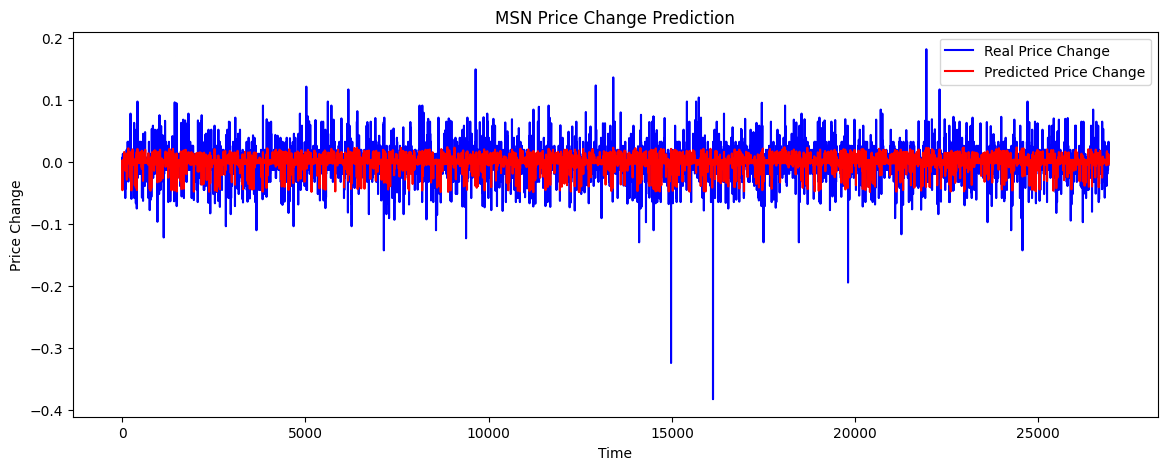

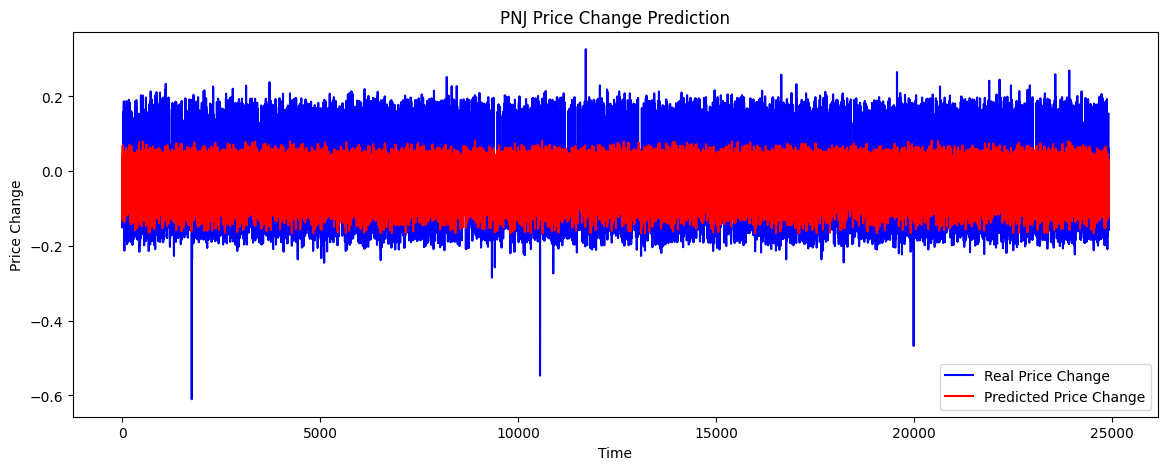

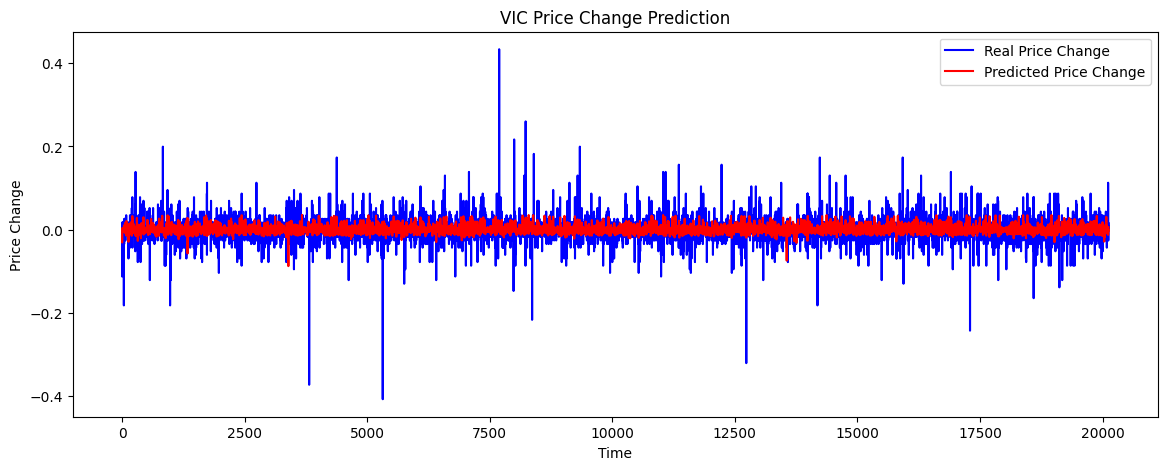

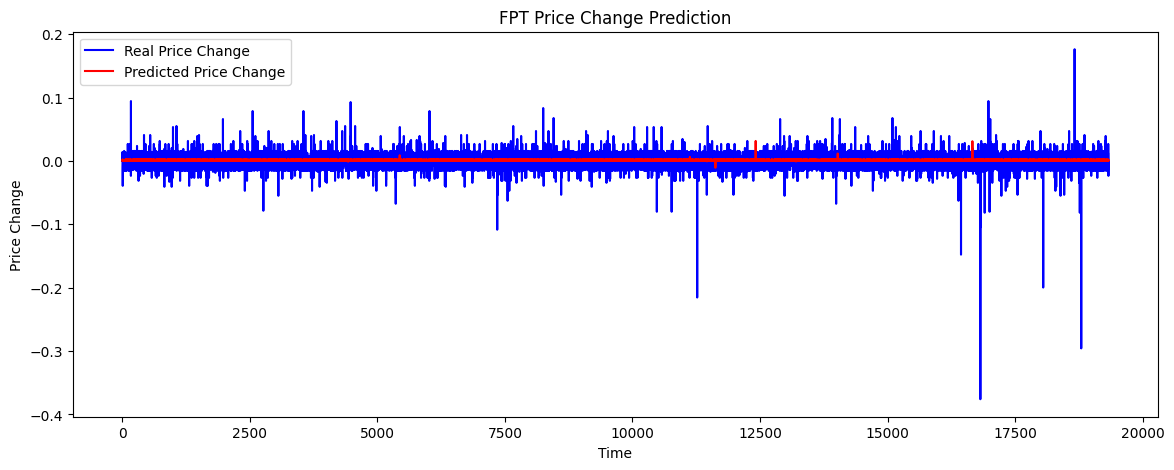

In [10]:
# Biểu đồ so sánh giữa dự đoán và giá trị thực tế
def plot_predictions(model, X_test, y_test, stock):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(14, 5))
    plt.plot(y_test.values, color='blue', label='Real Price Change')
    plt.plot(y_pred, color='red', label='Predicted Price Change')
    plt.title(f'{stock} Price Change Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price Change')
    plt.legend()
    plt.show()

for key in models.keys():
    plot_predictions(models[key], reshaped_data[key]['X_test'], reshaped_data[key]['y_test'], key)